# Load data

In [1]:
import torch
import torchvision.datasets as dsets

In [2]:
# Load train set
train = dsets.MNIST('../data', train=True, download=True)
imgs = train.data.reshape(-1, 784) / 255.0
labels = train.targets

# Shuffle and split into train and val
inds = torch.randperm(len(train))
imgs = imgs[inds]
labels = labels[inds]
val, Y_val = imgs[:6000], labels[:6000]
train, Y_train = imgs[6000:], labels[6000:]

# Load test set
test = dsets.MNIST('../data', train=False, download=True)
test, Y_test = test.data.reshape(-1, 784) / 255.0, test.targets

# Move test data to numpy
test_np = test.cpu().data.numpy()
Y_test_np = Y_test.cpu().data.numpy()

# Train model

In [3]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from torch.utils.data import TensorDataset, DataLoader

In [4]:
# Create model
device = torch.device('cuda', 1)
model = nn.Sequential(
    nn.Linear(784, 256),
    nn.ELU(),
    nn.Linear(256, 256),
    nn.ELU(),
    nn.Linear(256, 10)).to(device)

# Training parameters
lr = 1e-3
mbsize = 64
max_nepochs = 250
loss_fn = nn.CrossEntropyLoss()
lookback = 5
verbose = False

# Move to GPU
train = train.to(device)
val = val.to(device)
test = test.to(device)
Y_train = Y_train.to(device)
Y_val = Y_val.to(device)
Y_test = Y_test.to(device)

# Data loader
train_set = TensorDataset(train, Y_train)
train_loader = DataLoader(train_set, batch_size=mbsize, shuffle=True)

# Setup
optimizer = optim.Adam(model.parameters(), lr=lr)
min_criterion = np.inf
min_epoch = 0

# Train
for epoch in range(max_nepochs):
    for x, y in train_loader:
        # Move to device.
        x = x.to(device=device)
        y = y.to(device=device)

        # Take gradient step.
        loss = loss_fn(model(x), y)
        loss.backward()
        optimizer.step()
        model.zero_grad()

    # Check progress.
    with torch.no_grad():
        # Calculate validation loss.
        val_loss = loss_fn(model(val), Y_val).item()
        if verbose:
            print('{}Epoch = {}{}'.format('-' * 10, epoch + 1, '-' * 10))
            print('Val loss = {:.4f}'.format(val_loss))

        # Check convergence criterion.
        if val_loss < min_criterion:
            min_criterion = val_loss
            min_epoch = epoch
            best_model = deepcopy(model)
        elif (epoch - min_epoch) == lookback:
            if verbose:
                print('Stopping early')
            break

# Keep best model
model = best_model

In [5]:
# Add activation at output
model_activation = nn.Sequential(model, nn.Softmax(dim=1))

In [6]:
p = torch.tensor([torch.mean((Y_test == i).float()) for i in range(10)], device=device)
base_ce = loss_fn(torch.log(p.repeat(len(Y_test), 1)), Y_test)
ce = loss_fn(model(test), Y_test)

print('Base rate cross entropy = {:.4f}'.format(base_ce))
print('Model cross entropy = {:.4f}'.format(ce))

Base rate cross entropy = 2.3008
Model cross entropy = 0.0812


# Grouped importance (4x4 superpixels)

- Takes 2 minutes

In [7]:
import sage
import matplotlib.pyplot as plt

In [8]:
# Feature groups
width = 4
num_superpixels = 28 // width
groups = []
for i in range(num_superpixels):
    for j in range(num_superpixels):
        img = np.zeros((28, 28), dtype=int)
        img[width*i:width*(i+1), width*j:width*(j+1)] = 1
        img = img.reshape((784,))
        groups.append(np.where(img)[0])

In [9]:
# Setup and calculate
imputer = sage.GroupedMarginalImputer(model_activation, test_np[:512], groups)
estimator = sage.PermutationEstimator(imputer, 'cross entropy')
sage_values = estimator(test_np, Y_test_np, batch_size=128, thresh=0.05)

Setting up imputer for PyTorch model, assuming that any necessary output activations are applied properly. If not, please set up nn.Sequential with nn.Sigmoid or nn.Softmax


  0%|          | 0/1 [00:00<?, ?it/s]

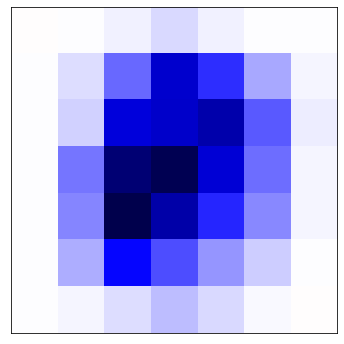

In [10]:
# Plot
plt.figure(figsize=(6, 6))
m = np.max(np.abs(sage_values.values))
plt.imshow(- sage_values.values.reshape(7, 7),
           cmap='seismic', vmin=-m, vmax=m)
plt.xticks([])
plt.yticks([])
plt.show()

# Grouped importance (2x2 superpixels)

- Takes 20 minutes

In [11]:
# Feature groups
width = 2
num_superpixels = 28 // width
groups = []
for i in range(num_superpixels):
    for j in range(num_superpixels):
        img = np.zeros((28, 28), dtype=int)
        img[width*i:width*(i+1), width*j:width*(j+1)] = 1
        img = img.reshape((784,))
        groups.append(np.where(img)[0])

In [12]:
# Setup and calculate
imputer = sage.GroupedMarginalImputer(model_activation, test_np[:512], groups)
estimator = sage.PermutationEstimator(imputer, 'cross entropy')
sage_values = estimator(test_np, Y_test_np, batch_size=128, thresh=0.05)

Setting up imputer for PyTorch model, assuming that any necessary output activations are applied properly. If not, please set up nn.Sequential with nn.Sigmoid or nn.Softmax


  0%|          | 0/1 [00:00<?, ?it/s]

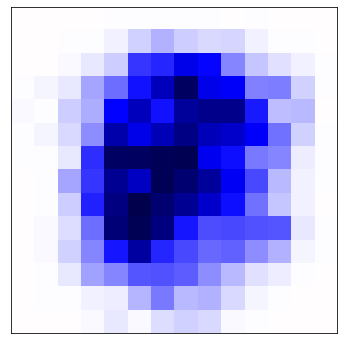

In [13]:
# Plot
plt.figure(figsize=(6, 6))
m = np.max(np.abs(sage_values.values))
plt.imshow(- sage_values.values.reshape(14, 14),
           cmap='seismic', vmin=-m, vmax=m)
plt.xticks([])
plt.yticks([])
plt.show()

# Individual pixel importance

- Takes 1.5 hours

In [14]:
# Setup and calculate
imputer = sage.MarginalImputer(model_activation, test_np[:512])
estimator = sage.PermutationEstimator(imputer, 'cross entropy')
sage_values = estimator(test_np, Y_test_np, batch_size=128, thresh=0.05)

Setting up imputer for PyTorch model, assuming that any necessary output activations are applied properly. If not, please set up nn.Sequential with nn.Sigmoid or nn.Softmax


  0%|          | 0/1 [00:00<?, ?it/s]

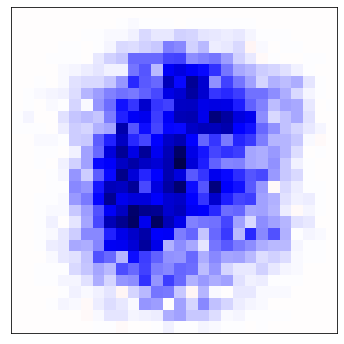

In [15]:
# Plot
plt.figure(figsize=(6, 6))
m = np.max(np.abs(sage_values.values))
plt.imshow(- sage_values.values.reshape(28, 28),
           cmap='seismic', vmin=-m, vmax=m)
plt.xticks([])
plt.yticks([])
plt.show()

# Individual pixels (fewer background examples)

- Takes 30 minutes

In [16]:
# Setup and calculate
imputer = sage.MarginalImputer(model_activation, test_np[:128])
estimator = sage.PermutationEstimator(imputer, 'cross entropy')
sage_values = estimator(test_np, Y_test_np, batch_size=512, thresh=0.05)

Setting up imputer for PyTorch model, assuming that any necessary output activations are applied properly. If not, please set up nn.Sequential with nn.Sigmoid or nn.Softmax


  0%|          | 0/1 [00:00<?, ?it/s]

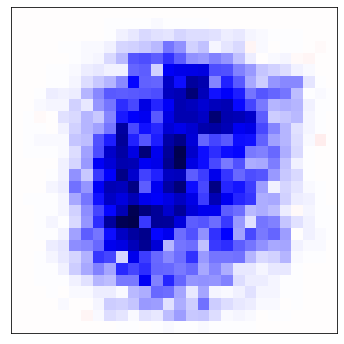

In [17]:
# Plot
plt.figure(figsize=(6, 6))
m = np.max(np.abs(sage_values.values))
plt.imshow(- sage_values.values.reshape(28, 28),
           cmap='seismic', vmin=-m, vmax=m)
plt.xticks([])
plt.yticks([])
plt.show()

# Individual pixels (zeros imputation)

- Takes 1 minute

In [18]:
# Setup and calculate
imputer = sage.DefaultImputer(model_activation, np.zeros(784))
estimator = sage.PermutationEstimator(imputer, 'cross entropy')
sage_values = estimator(test_np, Y_test_np, batch_size=512, thresh=0.05)

Setting up imputer for PyTorch model, assuming that any necessary output activations are applied properly. If not, please set up nn.Sequential with nn.Sigmoid or nn.Softmax


  0%|          | 0/1 [00:00<?, ?it/s]

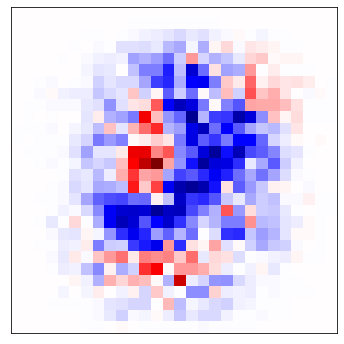

In [19]:
# Plot
plt.figure(figsize=(6, 6))
m = np.max(np.abs(sage_values.values))
plt.imshow(- sage_values.values.reshape(28, 28),
           cmap='seismic', vmin=-m, vmax=m)
plt.xticks([])
plt.yticks([])
plt.show()